COVID CASES PREDICTOR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from fbprophet import Prophet
from sklearn.metrics import r2_score

plt.style.use("ggplot")

df0 = pd.read_csv("CONVENIENT_global_confirmed_cases.csv")
df1 = pd.read_csv("CONVENIENT_global_deaths.csv")

In [3]:
world = pd.DataFrame({"Country":[],"Cases":[]})
world["Country"] = df0.iloc[:,1:].columns
world

,Country,Cases
0,Afghanistan,NaN
1,Albania,NaN
2,Algeria,NaN
3,Andorra,NaN
4,Angola,NaN
...,...,...
275,Vietnam,NaN
276,West Bank and Gaza,NaN
277,Yemen,NaN
278,Zambia,NaN


In [6]:
cases = []
for i in world["Country"]:
    cases.append(pd.to_numeric(df0[i][1:]).sum())
world["Cases"]=cases

In [88]:
country_list=list(world["Country"].values)
idx = 0
for i in country_list:
    sayac = 0
    for j in i:
        if j==".":
            i = i[:sayac]
            country_list[idx]=i
        elif j=="(":
            i = i[:sayac-1]
            country_list[idx]=i
        else:
            sayac += 1
    idx += 1
world["Country"]=country_list
world = world.groupby("Country")["Cases"].sum().reset_index()
world.head()

,Country,Cases
0,Afghanistan,158245.0
1,Albania,212021.0
2,Algeria,220415.0
3,Andorra,25289.0
4,Angola,86636.0


<BarContainer object of 195 artists>

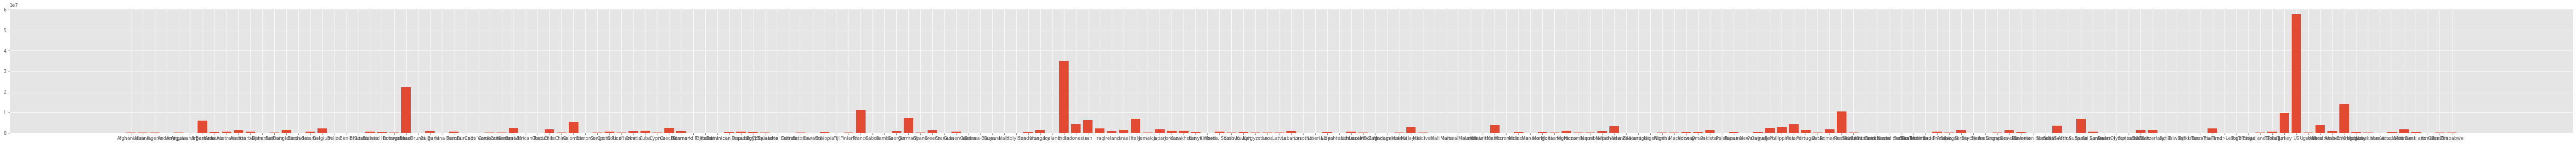

In [89]:
plt.figure(figsize=(100, 5))
plt.bar(world["Country"],world["Cases"])


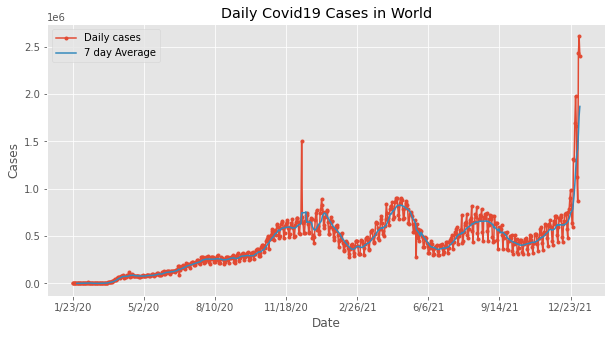

In [91]:
count = []
for i in range(1,len(df0)):
    count.append(sum(pd.to_numeric(df0.iloc[i,1:].values)))

df = pd.DataFrame()
df["Date"] = df0["Country/Region"][1:]
df["Cases"] = count
df=df.set_index("Date")

count = []
for i in range(1,len(df1)):
    count.append(sum(pd.to_numeric(df1.iloc[i,1:].values)))

df["Deaths"] = count

df.Cases.plot(title="Daily Covid19 Cases in World",marker=".",figsize=(10,5),label="Daily cases")
df.Cases.rolling(window=7).mean().plot(figsize=(10,5),label="7 day Average")
plt.ylabel("Cases")
plt.legend()
plt.show()

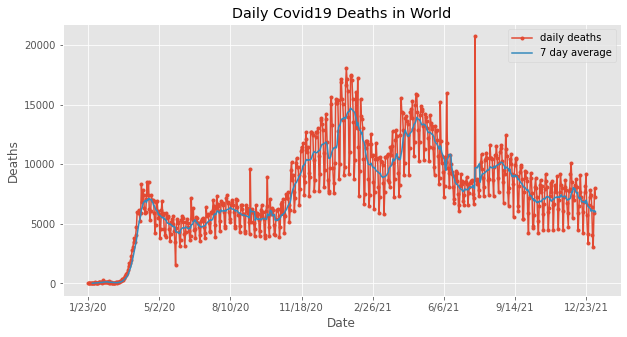

In [92]:
df.Deaths.plot(title="Daily Covid19 Deaths in World",marker=".",figsize=(10,5),label="daily deaths")
df.Deaths.rolling(window=7).mean().plot(figsize=(10,5),label="7 day average")
plt.ylabel("Deaths")
plt.legend()
plt.show()

# Facebook prophet model uses time series method for forecasting. 

In [93]:
class Fbprophet(object):
    def fit(self,data):
        self.data  = data
        self.model = Prophet(weekly_seasonality=True,daily_seasonality=False,yearly_seasonality=False)
        self.model.fit(self.data)
    
    def forecast(self,periods,freq):
        self.future = self.model.make_future_dataframe(periods=periods,freq=freq)
        self.df_forecast = self.model.predict(self.future)
        
    def plot(self,xlabel="Years",ylabel="Values"):
        self.model.plot(self.df_forecast,xlabel=xlabel,ylabel=ylabel,figsize=(9,4))
        self.model.plot_components(self.df_forecast,figsize=(9,6))
        
    def R2(self):
        return r2_score(self.data.y, self.df_forecast.yhat[:len(df)])

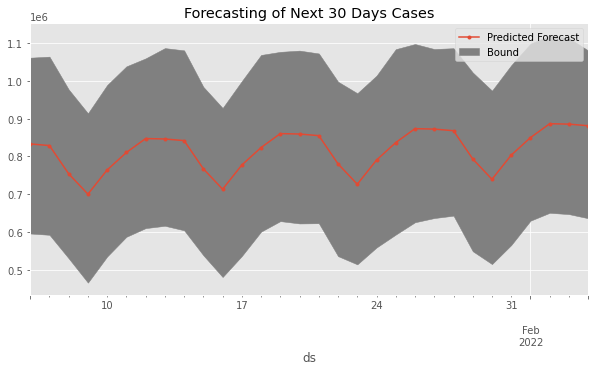

In [94]:
df_fb  = pd.DataFrame({"ds":[],"y":[]})
df_fb["ds"] = pd.to_datetime(df.index)
df_fb["y"]  = df.iloc[:,0].values

model = Fbprophet()
model.fit(df_fb)
model.forecast(30,"D")
model.R2()

forecast = model.df_forecast[["ds","yhat_lower","yhat_upper","yhat"]].tail(30).reset_index().set_index("ds").drop("index",axis=1)
forecast["yhat"].plot(marker=".",figsize=(10,5))
plt.fill_between(x=forecast.index, y1=forecast["yhat_lower"], y2=forecast["yhat_upper"],color="gray")
plt.legend(["Predicted Forecast","Bound"])
plt.title("Forecasting of Next 30 Days Cases")
plt.show()

In [95]:
date=input("Enter the date for which prediction is to be seen in yyyy/mm/dd format : ")
print("The cases on "+date+" are supposed to be around "+str(np.round(forecast.loc[date].yhat)))

Enter the date for which prediction is to be seen in yyyy/mm/dd format : 2022-01-06
The cases on 2022-01-06 are supposed to be around 832902.0
